# Programming assignment 2: KNN classifier

In this programming exercise, we will build a KNN classifier and apply it to a handwritten digit dataset (MNIST). Please download the datasets from Canvas and put them in the same folder of this iPython notebook.

Instructions for submission: please submit the following:
* Completed iPython notebook. We will inspect the code and run your notebook.
* Solutions to the corresponding problems




## 1. The MNIST dataset

`MNIST` is a classic database of handwritten digits that is commonly used for training various image processing systems. The MNIST database contains 60,000 training images and 10,000 testing images. In this notebook we will work with a subset of this data: a training set of 2,000 images and a test set of 500 images. Each image is given by 28 X 28 grayscale pixels.

First, let's first load the dataset check the basic statistics.


In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time
import random
#!pip install ProgressBar
from progressbar import ProgressBar
import math
#!{sys.executable} -m pip install ProgressBar
#!pip install ProgressBar
from random import randrange
from copy import copy, deepcopy

import glob
import json


In [69]:
#get item from json file into test data
def load_tester(path):
    final_data =[]
    chapter_data = []
    title_data = []
    
    with open(path) as f:
        data = json.load(f)
        
    for index in data:
        chapter_data.append(data[index]['chapData'])
        title_data.append(data[index]['title'])
        
    final_data.append(chapter_data)
    final_data.append(title_data)
    return np.asarray(final_data)

In [70]:
def searchListOfDicts(listOfDicts, attr, value):
    """
    Loops through a list of dictionaries and returns matching attribute value pair
    You can also pass it slug, silvermoon or type, pve
    returns a list containing all matching dictionaries 
    """
    matches = [record for record in listOfDicts if attr in record and record[attr] == value]
    return matches



#use use json to get data
dataOutputArray = load_tester('dataOutput.json')

#load all numpy files
numpy_vars = {}
count = 0
for np_name in glob.glob('*.np[yz]'):
    numpy_vars[count] = np.load(np_name)
    count +=1
    


## Load the training set
train_data =  np.asarray(dataOutputArray[0])
train_labels = dataOutputArray[1]
#train_labels = np.load('mnist_train_labels.npy')[:num_trn]


## Load the testing set
test_data = np.asarray([1,1])
test_labels = np.asarray(['true','true'])
#test_data = np.load('mnist_test_data.npy')[:num_tst,]
#test_labels = np.load('mnist_test_labels.npy')[:num_tst]


## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
#print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))



Training dataset dimensions:  (2,)
Testing dataset dimensions:  (2,)
Number of testing labels:  2
Training set distribution:
{'dÃ¬le': 2}
Test set distribution:
{'true': 2}


Now, let's randomly choose 10 images from the training dataset and visualize them.

In [71]:
#lets use this space to desplay something about the data we have
print(train_data)
print(train_labels)

[list([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1])
 list([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1])]
['dÃ¬le' 'dÃ¬le']


## 2. KNN based on Euclidean distance

Let's first experiment with _Euclidean distance_: for two vectors $x, y \in \mathbb{R}^d$, their Euclidean distance is defined as 
$$\|x - y\| = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}.$$
**Task P1:** Complete the following code section to calculate this distance. Copy the corresponding code to the problem set 1 solution pdf file.

In [72]:
## Computes squared Euclidean distance between two vectors.
def eucl_dist(x,y):
    # input:
    # x, y: vectorization of an image
    # output:
    # the euclidean distance between the two vectors
    
    ### STUDENT: YOUR CODE HERE
    
    d = len(x)
    sum = 0
    
    for i in range(d):  
        sum = sum + pow((x[i]-y[i]),2)
        
    sum = math.sqrt(sum) 
    return sum
### CODE ENDS

Now, let's try to compute the distance between some randomly chosen images.

In [73]:
#this gets random samples from the data set to test the distance
#index = random.sample(range(len(train_labels)), 10)

#for i in range(2):
#    # book index
#    k = i * 2
print("Distance from "+str(train_labels[0])+" to "+str(train_labels[1])+": "+
          str(eucl_dist(train_data[0],train_data[1])))

Distance from dÃ¬le to dÃ¬le: 0.0


Now, let's implement the K-nearest neighbor classification. 

**Task P2:** Complete the following code sections for `find_KNN` and `KNN_classifier`. Copy the corresponding code to the problem set 1 solution pdf file.

In [51]:
# Take a vector x and returns the indices of its K nearest neighbors in the training set: train_data
def find_KNN(x, train_data, train_labels, K, dist=eucl_dist):
    # Input: 
    # x: test point
    # train_data: training data X
    # train_labels: training data labels y
    # K: number of nearest neighbors considered
    # dist: default to be the eucl_dist that you have defined above
    # Output:
    # The indices of the K nearest neighbors to test point x in the training set
    
    ##### STUDENT: Your code here #####
    #list of distances from x
    distances = list()
    index = 0;
    #go through the training data
    for train_row in train_data:
        curr_dist=dist(train_row, x)
        #all the distances
        distances.append((index, curr_dist))
        index=index+1
    #sort    
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
   # return the lowest K distances
    for i in range(K):
        
        neighbors.append(distances[i][0])
    
    return neighbors
    ##### END OF CODE #####

Now, you should make use of the `find_KKN` function to define the KNN classifier.

In [52]:
# KNN classification
def KNN_classifier(x, train_data, train_labels,K,dist=eucl_dist):
    # Input:
    # x: test point
    # train_data: training data X
    # train_labels: training data labels y
    # K: number of nearest neighbors considered
    # dist: default to be the eucl_dist that you have defined above
    # Output:
    # the predicted label of the test point
    
    ##### STUDENT: Your code here #####
   
    #get the lowest K neighbors
    neighbors = find_KNN(x, train_data, train_labels,K,dist)
     
    if K is 1:
        # return the only label
        return train_labels[neighbors[0]]
    else:
        #value will be teh amount of times an number appears by index
        value = [0]*10
        #find the max alue of an item
        max =0;
        index = 0;
        #find the average of classification between K objects returned from find_KNN
        for item in neighbors:
            value[train_labels[item]]=value[train_labels[item]]+1
        #find the number that appeared most often and return it
        for i in range(10):
            if value[i]>max:
                max = value[i]
                index = i
        return index
    ##### END OF CODE #####

Now, let's examine how the code works for 1-NN (i.e., with K=1).

In [53]:
## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    plt.axis('off')
    if(dataset=="train"): 
        plt.imshow((train_data[index,]).reshape((28,28)), cmap=plt.cm.gray)
        label = train_labels[index]
    else:
        plt.imshow((test_data[index,]).reshape((28,28)), cmap=plt.cm.gray)
        label = test_labels[index]
    plt.show()
    print("Label " + str(label))
    return

**Task P3: Find one example of success case and one example of failed case for 1-NN. Print the outputs and copy them to the problem set solution file.**

A success case:
1-NN classification:  6
True label:  6
The test image:
5


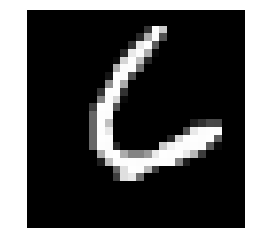

Label 6
The corresponding nearest neighbor image:


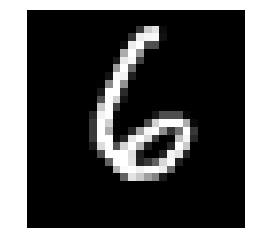

Label 6
A failure case:
NN classification:  9
True label:  3
The test image:


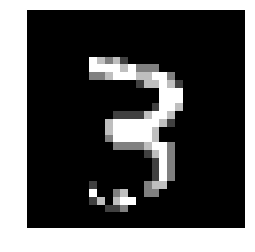

Label 3
The corresponding nearest neighbor image:


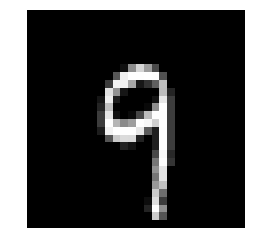

Label 9


In [ ]:
## A success case:
ind_success =  5 ### STUDENT: put one index of a success case here
#print(type(ind_success))
print("A success case:")
print("1-NN classification: ", KNN_classifier(test_data[ind_success,],train_data,train_labels,1,eucl_dist))
print("True label: ", test_labels[ind_success])
print("The test image:")
print(ind_success)
vis_image(ind_success, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_KNN(test_data[ind_success,],train_data,train_labels,1,eucl_dist)[0], "train")

## A failure case:
ind_fail =  24 ### STUDENT: put one index of a failued case here
print("A failure case:")
print("NN classification: ", KNN_classifier(test_data[ind_fail,],train_data,train_labels,1,eucl_dist))
print("True label: ", test_labels[ind_fail])
print("The test image:")
vis_image(ind_fail, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_KNN(test_data[ind_fail,],train_data,train_labels,1,eucl_dist)[0], "train")

Now let's apply our K-nearest neighbor classifier over the full data set with `K=3`. 

Note that to classify each test point, our code takes a full pass over each of the 2000 training examples. The following code takes about 8 seconds on 3.3 GHz Intel Core i. 

**Task P4: Report the outputs of the following code and copy them to the problem set solution file.**

In [ ]:
## Predict on each test data point (and time it!)
pbar = ProgressBar() # to show progress
t_before = time.time()
test_predictions = np.zeros(len(test_labels))
for i in pbar(range(len(test_labels))):   
    test_predictions[i] = KNN_classifier(test_data[i,],train_data,train_labels,1,eucl_dist)
    
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier with Euclidean distance: ", error)
print("Classification time (seconds) with Euclidean distance: ", t_after - t_before)

## 3. Different distance metrics

So far, we have been using the Euclidean distance. In this section, let's try the Manhattan distance. You will also design a distance function and report the results.

Recall that the Manhattan distance (a.k.a. $\ell_1$-norm) is given by:
$$\|x - y\|_1 = {\sum_{i=1}^d |x_i - y_i|}.$$

**Task P5: Complete the definition of `manh_dist` and report the outputs of the following code and copy them to the problem set solution file.**

In [31]:
## Computes Manhattan distance between two vectors.
def manh_dist(x,y):
    # input:
    # x, y: vectorization of an image of size 28 by 28
    # output:
    # the distance between the two vectors
    
    ### STUDENT: YOUR CODE HERE
    d = len(x)
    sum = 0.0
    
    for i in range(d):
        sum = sum + abs(x[i]-y[i])

    return sum
    ### CODE ENDS

pbar = ProgressBar() # to show progress
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = np.zeros(len(test_labels))
for i in pbar(range(len(test_labels))):   
    test_predictions[i] = KNN_classifier(test_data[i,],train_data,train_labels,3,manh_dist)
    
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier with Manhattan distance: ", error)
print("Classification time (seconds) with Manhattan distance: ", t_after - t_before)

Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Error of nearest neighbor classifier with Manhattan distance:  0.086
Classification time (seconds) with Manhattan distance:  961.9957449436188


**Task P6: Define your own distance function and write down the mathematical definition. Copy the code and the result to the problem set solution file. (2 bonus point) Can you improve over the Euclidean distance?**

In [32]:
## Compute a distance metric of your design
def my_dist(x,y):
    # input:
    # x, y: vectorization of an image of size 28 by 28 
    # output:
    # the distance between the two vectors
    
    ### STUDENT: YOUR CODE HERE
    #get the lenght of x and y
    
    #Squared chord distance (SCD)
    #we take the square root of each point,
    #find the diffrence and square that diffrence
    
    sum = 0.0

    d = len(x)
    
    for i in range(d):
        diff = abs(math.sqrt(x[i]))-abs(math.sqrt(y[i]))
        sum = sum +pow(diff,2)
    
    return sum
    ### CODE ENDS


In [95]:
pbar = ProgressBar() # to show progress
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = np.zeros(len(test_labels))
for i in pbar(range(len(test_labels))):   
    test_predictions[i] = KNN_classifier(test_data[i,],train_data,train_labels,3,my_dist)

t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier with the new distance: ", error)
print("Classification time (seconds) with the new distance: ", t_after - t_before)

Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN
Classifier
Find KNN


Error of nearest neighbor classifier with the new distance:  0.056
Classification time (seconds) with the new distance:  2049.391456604004


## 4. Cross-validation to select K

k-Fold Cross Validation (don't confuse this k with the K in KNN!) is a very useful technique to check how well a model performs when we apply it on an independent data. It is often used to flag problems caused by overfitting and selection bias. However, it brings an additional data processing load and time.

<img style="width:500px" src="K-fold-CV.png">

**Task P7: Implement the 5-fold cross validation to choose the best K (number of nearest neighbors) between 1 and 10 for KNN with Euclidean distance. Copy the code in the solution file and plot the 5-fold validation error with respect to K. Also plot the test error on the same figure. What do you observe?**

In [133]:
### STUDENT: YOUR CODE HERE

# Split a dataset and solutions into k folds
dataset_split = list()
dataset_copy = deepcopy(test_data)
labels_split = list()
labels_copy = list(test_labels)
#get the size each fold should be
fold_size = int(len(test_data) / 5)

#print(dataset_copy[0])

curr_index = 0
for i in range(5):
    
    fold = []
    solutions = list()
    
    while len(solutions) < fold_size:
    #palce a random index into the return list
        index = randrange(len(labels_copy))
        
        fold.append(dataset_copy[index])
        dataset_copy = np.delete(dataset_copy,index,0)
        solutions.append(labels_copy.pop(index))
        curr_index +=1 
        
    #print(len(dataset_copy))
    #print(len(solutions))
    #print(fold)
    dataset_split.append(fold)
    labels_split.append(solutions)


curr_fold = 0
k_value = 1
for fold in dataset_split:
    pbar = ProgressBar() # to show progress
    ## Predict on each test data point (and time it!)
    t_before = time.time()
    
    test_predictions = np.zeros(len(labels_split[0]))
    #print(dataset_split[0][0])
    for i in pbar(range(len(labels_split[0]))): 
        #print(test_data[i,])
        #print(dataset_split[i,])
        #print(labels_split[i])
        
        test_predictions[i] = KNN_classifier(fold[i],train_data,train_labels,curr_fold,eucl_dist)

    t_after = time.time()

    ## Compute the error
    err_positions = np.not_equal(test_predictions, labels_split[curr_fold])
    error = float(np.sum(err_positions))/len(labels_split[curr_fold])

    print("Error of nearest neighbor classifier with the new distance: ", error)
    print("Classification time (seconds) with the new distance: ", t_after - t_before)
    curr_fold = curr_fold+1
    k_value = k_value +2


100% |########################################################################|


Error of nearest neighbor classifier with the new distance:  0.91
Classification time (seconds) with the new distance:  1190.7693254947662


100% |########################################################################|


Error of nearest neighbor classifier with the new distance:  0.09
Classification time (seconds) with the new distance:  959.9625060558319


100% |########################################################################|


Error of nearest neighbor classifier with the new distance:  0.09
Classification time (seconds) with the new distance:  461.9388930797577


100% |########################################################################|


Error of nearest neighbor classifier with the new distance:  0.05
Classification time (seconds) with the new distance:  472.0826086997986


Error of nearest neighbor classifier with the new distance:  0.11
Classification time (seconds) with the new distance:  486.1788935661316


Congratulations! You have just implemented the KNN algorithm and tested it on the MNIST dataset!